In [21]:
# Loading all the Libraries which we will be using in our prediction
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from matplotlib import pyplot as plt
import random as rand
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from collections import Counter 

In [2]:
# Extracting the Folders which has images of different classes
with zipfile.ZipFile('data/chest.zip','r') as zip_file:
  zip_file.extractall('')

In [3]:
# USING IMAGE DATA GENERATOR TO DO THE IMAGE AUGMENTATION ON OUR DATASET
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) 

In [4]:
# Loading the data
train_data = train_datagen.flow_from_directory('data/chest_xray/train', target_size=(224, 224), batch_size=32, class_mode='categorical')

test_data = test_datagen.flow_from_directory('data/chest_xray/test', target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Names of all the classes present
all_classes = train_data.class_indices
print(all_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
# Counting the number of images we have for each class
counter = Counter(train_data.classes)
print(counter)

Counter({1: 3875, 0: 1341})


In [7]:
# Taking the maximum value from our counter variable which we will use further to infer class weights
max_val = float(max(counter.values()))

In [8]:
# Adding weights to the class which has fewer number of samples
class_weights = {class_id: max_val/num_images for class_id, num_images in counter.items()}
print(class_weights)

{0: 2.889634601043997, 1: 1.0}


In [9]:
# Loading the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [10]:
# Adding custom top layers for object detection
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(all_classes), activation='softmax')(x)

In [11]:
# Creating a model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,407,874 (154.14 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
# Callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('object_detection_model.keras', monitor='val_loss', verbose=1, save_best_only=True)  

In [16]:
# Training the model
try:
    history = model.fit(train_data, validation_data=test_data, epochs=10, verbose=1, class_weight=class_weights, callbacks=[early_stopping, model_checkpoint])
except Exception as e:
    print(f"An error occurred during training: {str(e)}")

Epoch 1/10


e:\Pneumonia Detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8201 - loss: 2.2060 
Epoch 1: val_loss improved from inf to 0.23891, saving model to object_detection_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 3162s 19s/step - accuracy: 0.8206 - loss: 2.1975 - val_accuracy: 0.9167 - val_loss: 0.2389
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9397 - loss: 0.2475 
Epoch 2: val_loss did not improve from 0.23891
163/163 ━━━━━━━━━━━━━━━━━━━━ 2030s 12s/step - accuracy: 0.9397 - loss: 0.2476 - val_accuracy: 0.9215 - val_loss: 0.2419
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9420 - loss: 0.2202
Epoch 3: val_loss did not improve from 0.23891
163/163 ━━━━━━━━━━━━━━━━━━━━ 1539s 9s/step - accuracy: 0.9419 - loss: 0.2203 - val_accuracy: 0.9119 - val_loss: 0.2756
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9408 - loss: 0.2290
Epoch 4: val_loss did not improve from 0.23891
163/163 ━━━━━━━━━━━━━━━━━━━━ 1539s 9s/step - accuracy: 0.9408 - loss: 0.22

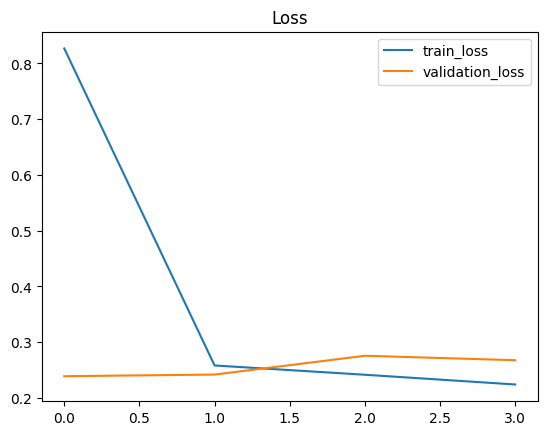

In [17]:
# Plotting the loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Loss')
plt.legend()
plt.show()

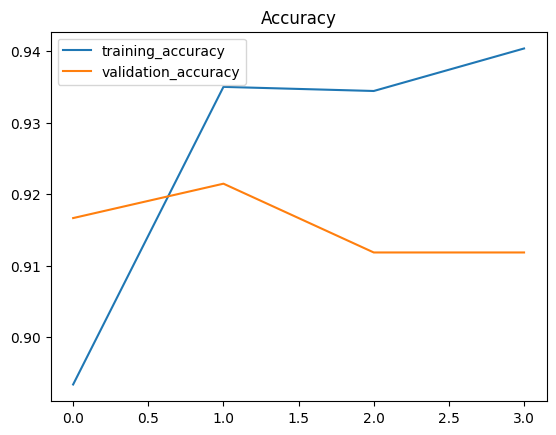

In [18]:
# Plotting the accuracy
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [22]:
# Checking the confusion matrix
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(test_data.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = list(all_classes.keys())
print(classification_report(test_data.classes, y_pred, target_names=target_names))

20/20 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step
Confusion Matrix
[[ 83 151]
 [127 263]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.40      0.35      0.37       234
   PNEUMONIA       0.64      0.67      0.65       390

    accuracy                           0.55       624
   macro avg       0.52      0.51      0.51       624
weighted avg       0.55      0.55      0.55       624



In [23]:
# Saving the model
model.save('object_detection_model.h5')